In [1]:
!pip install segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.2 MB/s eta 0:00:00


In [2]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"


In [3]:
import numpy as np 
import pandas as pd 
import time
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models.losses import DiceLoss
from segmentation_models.metrics import FScore
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.callbacks import Callback


2024-07-13 23:35:47.219770: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-13 23:35:47.219885: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-13 23:35:47.331276: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Segmentation Models: using `tf.keras` framework.


In [4]:
#завантаження даних
df = pd.read_csv('/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv')
image_dir = '/kaggle/input/airbus-ship-detection/train_v2'
df

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN


In [5]:
# групування EncodedPixels у список та зменшення загальної кількості зображень 

df['EncodedPixels'] = df['EncodedPixels'].astype(str) 

df_listed = df.groupby('ImageId')['EncodedPixels'].apply(lambda x: x.tolist()).reset_index()

grouped = df_listed.groupby(df_listed['EncodedPixels'].apply(lambda x: x == ['nan']))

nan_group = grouped.filter(lambda x: x['EncodedPixels'].iloc[0] == ['nan'])
not_nan_group = grouped.filter(lambda x: x['EncodedPixels'].iloc[0] != ['nan'])

reduced_not_nan_group = not_nan_group.sample(1500)
reduced_nan_group = nan_group.sample(1500)

df_balanced = pd.concat([reduced_not_nan_group, reduced_nan_group])
df_balanced

,ImageId,EncodedPixels
75650,649bc21de.jpg,[24390 1 25156 4 25922 6 26689 8 27455 11 2822...
182075,f221ea400.jpg,[267384 55 268152 55 268920 55 269688 55 27045...
101602,8714a9fe4.jpg,[522020 3 522788 7 523556 12 524324 16 525092 ...
175039,e8c43eb95.jpg,[109183 4 109951 7 110719 7 111487 7 112255 7 ...
81082,6bb03cf77.jpg,[262314 2 263082 5 263849 8 264617 11 265385 1...
...,...,...
114240,97e47de98.jpg,[nan]
177048,eb79f8661.jpg,[nan]
119430,9ed652123.jpg,[nan]
95523,7efbcab9e.jpg,[nan]


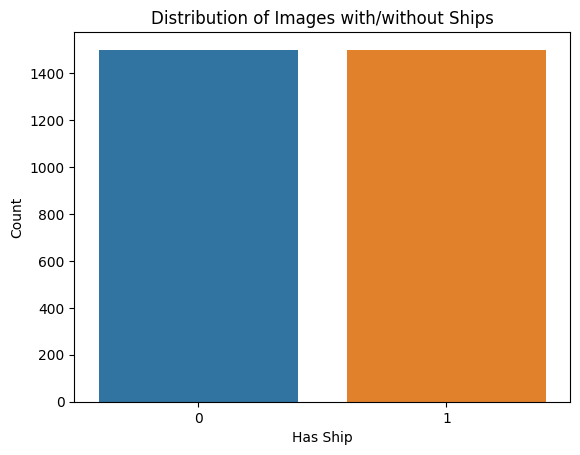

In [6]:
# візуалізація співвідношення
df_balanced_to_viz = df_balanced.copy()

df_balanced_to_viz['has_ship'] = df_balanced_to_viz['EncodedPixels'].apply(lambda x: 0 if x == ['nan'] else 1)


grouped_df_to_viz = df_balanced_to_viz.groupby('ImageId')['has_ship'].max().reset_index()


sns.countplot(x='has_ship', data=grouped_df_to_viz)
plt.xlabel('Has Ship')
plt.ylabel('Count')
plt.title('Distribution of Images with/without Ships')
plt.show()

In [7]:
# створення генератора даних 

class ShipDataset(Sequence):
    def __init__(self, df, image_dir, image_shape=(768,768), batch_size=32, shuffle=True, transform=None, preprocessing_fn=None):
        self.df = df
        self.image_dir = image_dir
        self.shape = image_shape
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.transform = transform
        self.preprocessing_fn = preprocessing_fn
        
        #метод ініціалізаціі індексів та перемішування при необхідності
        self.on_epoch_end()
    
    def __len__(self):
        #повертає кількість батчів на одну епоху
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, idx):
        #генерування одного батчу даних
        
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        
        images, masks = [], []
        for _, row in batch_df.iterrows():
            image, mask = self.load_image_and_mask(row)
            images.append(image)
            masks.append(mask)
        
        images = np.array(images)
        masks = np.array(masks)
        
        #зміна типу та додавання додаткового виміру для масок
        masks = masks.astype(np.float32)
        masks = np.expand_dims(masks, axis=-1)
        
        if self.transform:
            images = np.array([self.transform(image=image)['image'] for image in images])
        
        if self.preprocessing_fn:
            images = self.preprocessing_fn(images)
        
        return images, masks
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.df))
        
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def load_image_and_mask(self, row):
        image_name = row['ImageId']
        image_path = os.path.join(self.image_dir, image_name)
        image = img_to_array(load_img(image_path, target_size=self.shape))
        
        rles = row['EncodedPixels']
        mask = self.combine_rle_masks(rles, self.shape)
        
        return image, mask
    
    def rle_to_mask(self, rle, shape):
        
        #конвертація RLE рядка у маску
        
        mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)

        if rle == 'nan':
            return mask.reshape(shape)

        rle_nums = list(map(int, rle.split()))
        starts = rle_nums[0::2]
        lengths = rle_nums[1::2]
        starts = [start - 1 for start in starts]

        for start, length in zip(starts, lengths):
            mask[start:start + length] = 1

        return mask.reshape(shape).T

    def combine_rle_masks(self, rles, shape):
        
        # комбінування масок в одну 
        
        combined_mask = np.zeros(shape, dtype=np.uint8)

        for rle in rles:
            if rle != 'nan':
                mask = self.rle_to_mask(rle, shape)
                combined_mask = np.maximum(combined_mask, mask)

        return combined_mask

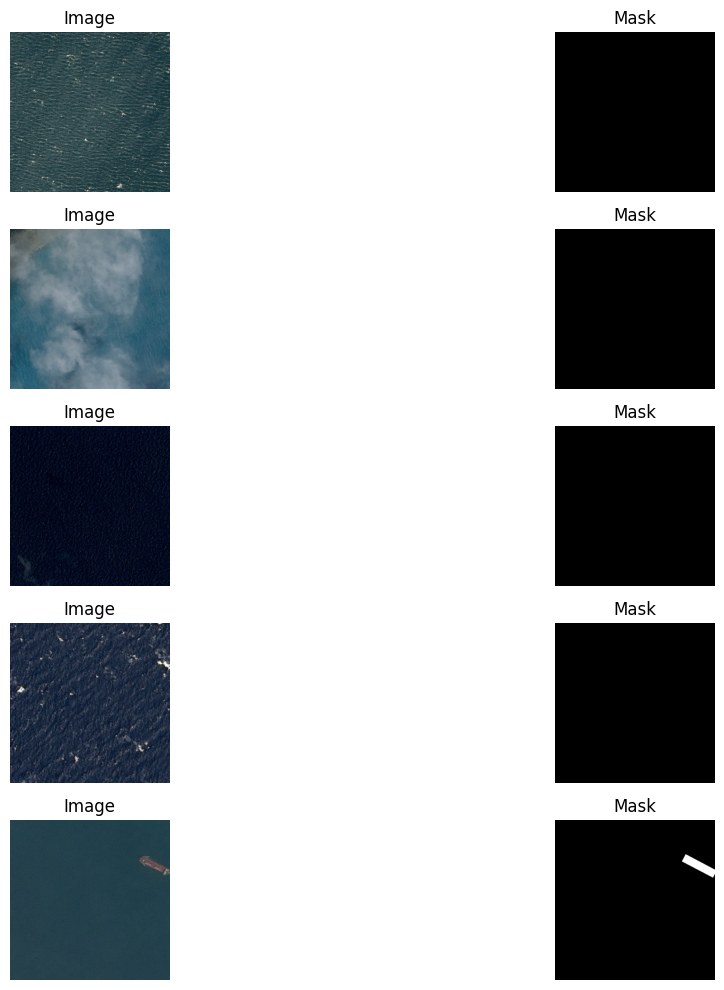

In [8]:
#візуалізація зображень та іх масок 

vizualize_dataset = ShipDataset(df_balanced, image_dir, batch_size=5, image_shape=(768, 768))

images, masks = vizualize_dataset[0]

plt.figure(figsize=(15, 10))
for i in range(len(images)):
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(images[i].astype('uint8'))
    plt.title('Image')
    plt.axis('off')

    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(masks[i], cmap='gray')
    plt.title('Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
# розділення даних на тренувальні та валідаційні

train_df, val_df = train_test_split(df_balanced, train_size=0.8, shuffle=True)
train_df

,ImageId,EncodedPixels
43223,399725533.jpg,[nan]
153904,cca118023.jpg,[nan]
91867,7a03cf73a.jpg,[nan]
178224,ed0109f13.jpg,[550984 1 551751 3 552519 4 553286 4 554053 5 ...
40383,35e74684d.jpg,[181 9 949 9 1717 9 2485 9 3253 9 4021 9 4789 4]
...,...,...
107221,8e9090c7d.jpg,[nan]
141673,bc4f5d30a.jpg,[nan]
53245,46f434498.jpg,[nan]
185014,f60686469.jpg,[2165 1 2932 4 3700 5 4467 7 5234 10 6001 12 6...


In [10]:
# створення датасетів
train_dataset = ShipDataset(train_df, image_dir, image_shape=(768,768), batch_size=16, preprocessing_fn=preprocess_input)
val_dataset = ShipDataset(val_df, image_dir, image_shape=(768,768), batch_size=16, preprocessing_fn=preprocess_input)

In [11]:
#створення моделі
model = sm.Unet('resnet18',
                input_shape=(768, 768, 3),
                classes=1,
                activation='sigmoid')

for layer in model.layers:
    if 'decoder' not in layer.name:
        layer.trainable = False
    if layer.name in ['final_conv', 'sigmoid']:
        layer.trainable = True

optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss=DiceLoss(), metrics=[FScore()])

44920640/44920640 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 768, 768,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 768, 768,  │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 774, 774,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 384, 384,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 384, 384,  │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 384, 384,  │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 386, 386,  │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 192, 192,  │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 192, 192,  │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 192, 192,  │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 194, 194,  │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 192, 192,  │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 192, 192,  │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 192, 192,  │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 194, 194,  │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 192, 192,  │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 192, 192,  │      4,096 │ stage1_unit1_rel

 Total params: 14,340,570 (54.70 MB)

 Trainable params: 3,151,697 (12.02 MB)

 Non-trainable params: 11,188,873 (42.68 MB)

In [13]:
for layer in model.layers:
    print(f'{layer.name}: Trainable={layer.trainable}')

data: Trainable=False
bn_data: Trainable=False
zero_padding2d: Trainable=False
conv0: Trainable=False
bn0: Trainable=False
relu0: Trainable=False
zero_padding2d_1: Trainable=False
pooling0: Trainable=False
stage1_unit1_bn1: Trainable=False
stage1_unit1_relu1: Trainable=False
zero_padding2d_2: Trainable=False
stage1_unit1_conv1: Trainable=False
stage1_unit1_bn2: Trainable=False
stage1_unit1_relu2: Trainable=False
zero_padding2d_3: Trainable=False
stage1_unit1_conv2: Trainable=False
stage1_unit1_sc: Trainable=False
add: Trainable=False
stage1_unit2_bn1: Trainable=False
stage1_unit2_relu1: Trainable=False
zero_padding2d_4: Trainable=False
stage1_unit2_conv1: Trainable=False
stage1_unit2_bn2: Trainable=False
stage1_unit2_relu2: Trainable=False
zero_padding2d_5: Trainable=False
stage1_unit2_conv2: Trainable=False
add_1: Trainable=False
stage2_unit1_bn1: Trainable=False
stage2_unit1_relu1: Trainable=False
zero_padding2d_6: Trainable=False
stage2_unit1_conv1: Trainable=False
stage2_unit1_bn2:

In [14]:
# створення класу для відстежування процессу навчання

class TrainingStats(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        train_loss = logs.get('loss')
        val_loss = logs.get('val_loss')
        train_recall = logs.get('f1-score')
        val_recall = logs.get('val_f1-score')
        print(f"\n Epoch {epoch + 1}/{self.params['epochs']}, "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train score: {train_recall:.4f}, Val score: {val_recall:.4f}, "
              f"Epoch Time: {epoch_time:.2f}")

In [15]:
import warnings
warnings.filterwarnings('ignore', category=Warning)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[TrainingStats()])

model.save('saved_model.keras')

Epoch 1/10


2024-07-13 23:37:11.839515: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng2{k2=1,k3=0} for conv (f32[16,32,384,384]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,128,384,384]{3,2,1,0}, f32[32,128,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-13 23:37:11.879079: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.039683618s
Trying algorithm eng2{k2=1,k3=0} for conv (f32[16,32,384,384]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,128,384,384]{3,2,1,0}, f32[32,128,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-13 23:37:12.879379: E e

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 994ms/step - f1-score: 0.0103 - loss: 0.9897
 Epoch 1/10, Train Loss: 0.9860, Val Loss: 0.9880, Train score: 0.0140, Val score: 0.0120, Epoch Time: 442.62
150/150 ━━━━━━━━━━━━━━━━━━━━ 443s 1s/step - f1-score: 0.0103 - loss: 0.9897 - val_f1-score: 0.0120 - val_loss: 0.9880
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 993ms/step - f1-score: 0.0235 - loss: 0.9765
 Epoch 2/10, Train Loss: 0.9701, Val Loss: 0.9754, Train score: 0.0299, Val score: 0.0243, Epoch Time: 168.29
150/150 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - f1-score: 0.0235 - loss: 0.9765 - val_f1-score: 0.0243 - val_loss: 0.9754
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 993ms/step - f1-score: 0.0503 - loss: 0.9497
 Epoch 3/10, Train Loss: 0.9382, Val Loss: 0.9366, Train score: 0.0618, Val score: 0.0639, Epoch Time: 168.80
150/150 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - f1-score: 0.0504 - loss: 0.9496 - val_f1-score: 0.0639 - val_loss: 0.9366
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - f1-scor

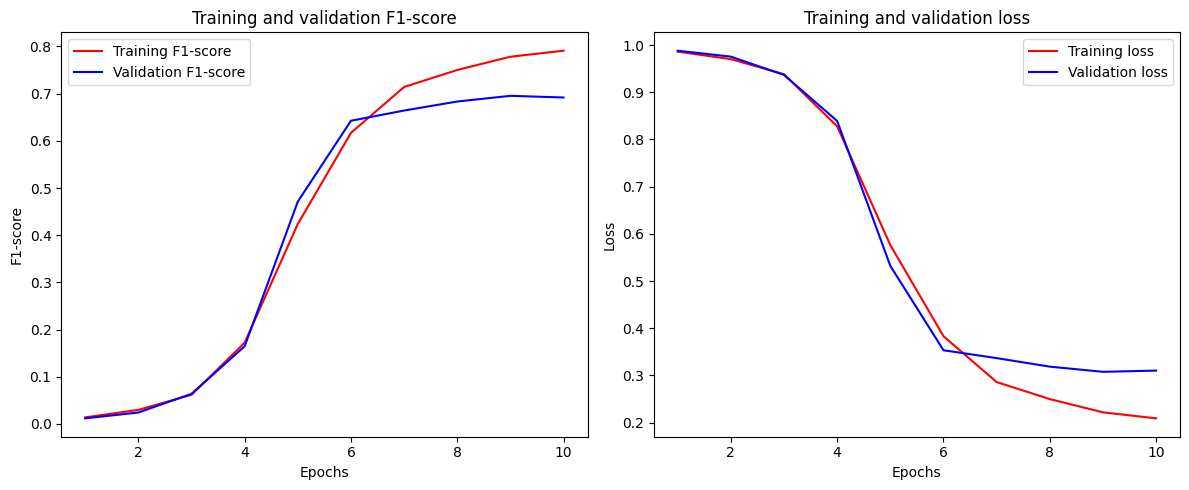

In [16]:
# Візуалізація історії тренування моделі

def plot_training(history):
    f1_score = history.history['f1-score']
    val_f1_score = history.history['val_f1-score']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(f1_score) + 1)

    plt.figure(figsize=(12, 5))

    # Plot F1-score
    plt.subplot(1, 2, 1)
    plt.plot(epochs, f1_score, 'r', label='Training F1-score')
    plt.plot(epochs, val_f1_score, 'b', label='Validation F1-score')
    plt.title('Training and validation F1-score')
    plt.xlabel('Epochs')
    plt.ylabel('F1-score')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training(history)